In [1]:
# camera look at model
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import src.draw3d

c:\Users\gemin\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
c:\Users\gemin\miniconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.23-246-g3d31191b-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
fr = np.array([1.0, 0.8, 0.6])
to = np.array([0.0, 0.0, 0.0])

forward = to-fr
forward = forward / np.linalg.norm(forward)

In [3]:
up = np.array([0.0, 1.0, 0.0])

right = np.cross(forward, up)
right = right / np.linalg.norm(right)
right

array([ 0.51449576,  0.        , -0.85749293])

In [4]:
up = np.cross(forward, right)
up = up / np.linalg.norm(up)
up

array([ 0.48507125, -0.82462113,  0.29104275])

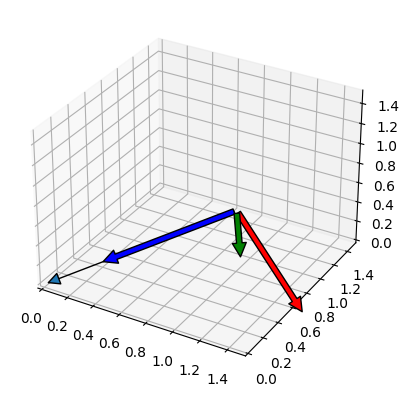

In [5]:
ax = plt.figure().add_subplot(projection='3d')

ax.set_xlim([0.,1.5])
ax.set_ylim([0.,1.5])
ax.set_zlim([0.,1.5])

ax.arrow3D(fr[0], fr[1], fr[2], to[0]-fr[0], to[1]-fr[1], to[2]-fr[2], mutation_scale=20, arrowstyle="-|>")
ax.arrow3D(fr[0], fr[1], fr[2], forward[0], forward[1], forward[2], mutation_scale=20, fc='blue')
ax.arrow3D(fr[0], fr[1], fr[2], right[0], right[1], right[2], mutation_scale=20, fc='red')
ax.arrow3D(fr[0], fr[1], fr[2], up[0], up[1], up[2], mutation_scale=20, fc='green')

plt.show()


In [6]:
import torch
import torch.nn.functional as F

def spherical_to_cartesian(distance, azimuth, elevation):
    azimuth = torch.deg2rad(azimuth)
    elevation = torch.deg2rad(elevation)

    x = distance * torch.cos(elevation) * torch.cos(azimuth)
    y = distance * torch.cos(elevation) * torch.sin(azimuth)
    z = distance * torch.sin(elevation)

    return x, y, z

def look_at_camera_rotation(camera_pos, target_pos, up):
    # [batch_size, 3]
    f = (target_pos - camera_pos) 
    f = F.normalize(f, dim=-1)
    r = torch.cross(up, f, dim=-1)
    r = F.normalize(r, dim=-1)
    u = torch.cross(f, r, dim=-1)
    u = F.normalize(u, dim=-1)

    r_mat = torch.zeros((camera_pos.shape[0],3,3)) # rotation matrix [batch_size, 3, 3]

    # column major
    r_mat = torch.eye(4).repeat(camera_pos.shape[0], 1, 1)
    r_mat[:, :-1, 0] = r
    r_mat[:, :-1, 1] = u
    r_mat[:, :-1, 2] = -f
    return r_mat

def camera_pos_matrix_from(distance, azimuth, elevation):
    x, y, z = spherical_to_cartesian(distance, azimuth, elevation)
    camera_pos = torch.stack([x, y, z], axis=-1) # [batch_size, 3]
    
    # the origin
    target_pos = torch.zeros((x.shape[0], 3))

    # random or y unit vector
    up = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0).repeat(target_pos.shape[0], 1)
    # compute view matrix
    rmat = look_at_camera_rotation(camera_pos, target_pos, up)
    rmat[:, :-1, 3] = camera_pos
    return rmat


In [7]:
import math
def generate_even_grid_points(num_views):
    num_views -= 2
    
    # find the two closest integers to the square root of num_views
    root = int(np.sqrt(num_views))
    for i in range(root, 0, -1):
        if num_views % i == 0:
            n_elev, n_azim = i, num_views // i
            break

    azim = np.linspace(0, 360, n_azim, endpoint=False)
    elev  = np.linspace(-90, 90, n_elev+2)[1:-1]
    azim, elev = np.meshgrid(azim, elev) # [n_elev, n_azim]
    azim = azim.ravel()
    elev = elev.ravel()
    azim = np.concatenate(([0], azim, [0]), axis=0)
    elev = np.concatenate(([0], elev, [180]), axis=0)
    return azim, elev
    

In [8]:
distance = 5.0
n_cam = 38

azim, elev = generate_even_grid_points(n_cam)
azim = torch.tensor(azim, dtype=torch.float)
elev = torch.tensor(elev, dtype=torch.float)


tensor(300.) tensor(-12.8571)


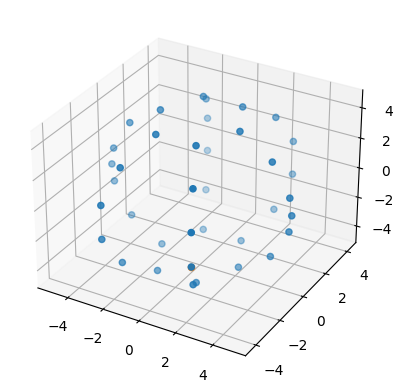

In [9]:
# Plot the camera positions
x, y, z = spherical_to_cartesian(distance, azim, elev)
i=18
print(azim[i], elev[i])

ax = plt.figure().add_subplot(projection="3d")
ax.scatter(x.numpy(), y.numpy(), z.numpy())
ax.scatter(x.numpy()[i], y.numpy()[i], z.numpy()[i])
plt.show()

In [10]:
camera_pose = camera_pos_matrix_from(distance, azim, elev)

cam_p = camera_pose[:, :-1, -1].numpy()
cam_d = torch.bmm(camera_pose[:, :-1, :-1 ], torch.tensor([0, 0, -1.0]).reshape(1, 3, 1).repeat((n_cam, 1, 1))).squeeze(-1).numpy()

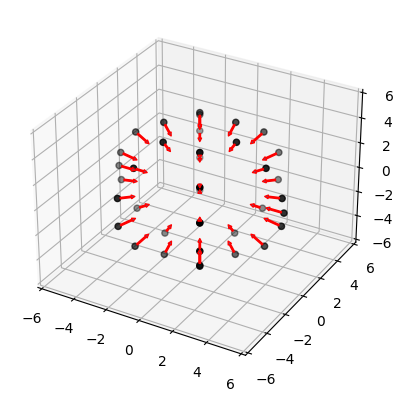

In [11]:
# plot the camera dirctions
arrow_length = 1.2
cam_d = cam_d*1.2

ax = plt.figure().add_subplot(projection='3d')
ax.set_xlim([-6.0,6.0])
ax.set_ylim([-6.0,6.0])
ax.set_zlim([-6.0,6.0])

# plot the position
ax.scatter(x.numpy(), y.numpy(), z.numpy(), c="k")
# plot the direction arrow
for i in range(n_cam):
    ax.arrow3D(cam_p[i, 0], cam_p[i, 1], cam_p[i, 2], cam_d[i,0], cam_d[i,1], cam_d[i,2], mutation_scale=5, ec="red")
plt.show()
